In [ ]:
!pip install rasterio geopandas ultralytics
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python mediapipe

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-314abpr4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-314abpr4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import time
import json
import torch
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import PatchCollection

from segment_anything import sam_model_registry, SamPredictor

In [ ]:
start_cpu_time = time.process_time()


def apply_global_nms(detection_info, all_polygons, detection_masks, iou_threshold=0.3):

    if len(detection_info) == 0:
        return detection_info, all_polygons, detection_masks

    # Sort by confidence (highest first)
    indices = sorted(range(len(detection_info)),
                    key=lambda i: detection_info[i]['confidence'],
                    reverse=True)

    keep = []
    removed = set()

    for i in indices:
        if i in removed:
            continue

        keep.append(i)
        poly_i = all_polygons[i]

        # Check against remaining detections
        for j in indices:
            if j <= i or j in removed:
                continue

            poly_j = all_polygons[j]

            try:
                # Calculate IoU
                intersection = poly_i.intersection(poly_j).area
                union = poly_i.union(poly_j).area

                if union > 0:
                    iou = intersection / union
                    if iou > iou_threshold:
                        removed.add(j)
            except Exception as e:
                continue

    # Filter to keep only non-duplicate detections
    detection_info_filtered = [detection_info[i] for i in keep]
    all_polygons_filtered = [all_polygons[i] for i in keep]
    detection_masks_filtered = [detection_masks[i] for i in keep]

    print(f"Global NMS: {len(detection_info)} -> {len(detection_info_filtered)} detections")

    return detection_info_filtered, all_polygons_filtered, detection_masks_filtered


def detect_with_yolo(image_path, model, tile_size=640, overlap=128,
                     resolution=1.0, conf_threshold=0.20, iou_threshold=0.45,
                     max_det=1000, apply_nms=True, nms_iou=0.3):
    """
    Detect objects using YOLO model and return bounding boxes
    """
    boxes_list = []  # List of all bounding boxes with metadata

    # Load image
    try:
        with rasterio.open(image_path) as src:
            original_width, original_height = src.width, src.height
            transform = src.transform
            crs = src.crs

            print(f"Original image size: {original_width}x{original_height}")

            # Read full image
            if src.count >= 3:
                full_image = src.read([1, 2, 3])
                full_image = np.transpose(full_image, (1, 2, 0))
            else:
                full_image = src.read(1)
                if len(full_image.shape) == 2:
                    full_image = cv2.cvtColor(full_image, cv2.COLOR_GRAY2RGB)

            full_image = np.clip(full_image, 0, 255).astype(np.uint8)
    except:
        print("Loading as regular image (not GeoTIFF)...")
        full_image = cv2.imread(image_path)
        if full_image is None:
            raise ValueError(f"Could not load image from {image_path}")

        full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
        original_height, original_width = full_image.shape[:2]

        print(f"Original image size: {original_width}x{original_height}")

        from rasterio.transform import from_bounds
        transform = from_bounds(0, 0, original_width, original_height, original_width, original_height)
        crs = None

    # Calculate scaled dimensions
    new_width = int(original_width * resolution)
    new_height = int(original_height * resolution)
    print(f"Processing at: {new_width}x{new_height} (resolution={resolution})")

    resized_image = cv2.resize(full_image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Create tiles
    tile_positions = []
    step_size = tile_size - overlap

    for y in range(0, new_height, step_size):
        for x in range(0, new_width, step_size):
            x_end = min(x + tile_size, new_width)
            y_end = min(y + tile_size, new_height)
            tile_positions.append((x, y, x_end, y_end))

    print(f"Processing {len(tile_positions)} tiles with YOLO...")

    # Process tiles
    for x, y, x_end, y_end in tqdm(tile_positions, desc="YOLO Detection"):
        win_w = x_end - x
        win_h = y_end - y

        # Extract tile
        tile = resized_image[y:y_end, x:x_end]

        if tile.shape[:2] != (tile_size, tile_size):
            tile = cv2.resize(tile, (tile_size, tile_size))
            scale_x = win_w / tile_size
            scale_y = win_h / tile_size
        else:
            scale_x = scale_y = 1.0

        tile = np.ascontiguousarray(tile)

        # Run YOLO detection
        results = model.predict(
            source=tile,
            conf=conf_threshold,
            iou=iou_threshold,
            max_det=max_det,
            save_txt=False,
            save_conf=True,
            verbose=False
        )

        if results[0].boxes is not None and len(results[0].boxes) > 0:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confidences = results[0].boxes.conf.cpu().numpy()

            # Transform boxes to original image coordinates
            for i in range(len(boxes)):
                x1, y1, x2, y2 = boxes[i]

                # Scale back to tile dimensions
                x1_scaled = x1 * scale_x
                y1_scaled = y1 * scale_y
                x2_scaled = x2 * scale_x
                y2_scaled = y2 * scale_y

                # Transform to global scaled image coordinates
                x1_global = x1_scaled + x
                y1_global = y1_scaled + y
                x2_global = x2_scaled + x
                y2_global = y2_scaled + y

                # Transform to original image coordinates
                x1_orig = int(x1_global / resolution)
                y1_orig = int(y1_global / resolution)
                x2_orig = int(x2_global / resolution)
                y2_orig = int(y2_global / resolution)

                boxes_list.append({
                    'bbox': [x1_orig, y1_orig, x2_orig, y2_orig],
                    'confidence': float(confidences[i])
                })

    print(f"YOLO detected {len(boxes_list)} boxes before NMS")

    # Remove duplicates
    if apply_nms and len(boxes_list) > 0:
        boxes_list = apply_nms_to_boxes(boxes_list, nms_iou)
        print(f"After NMS: {len(boxes_list)} boxes")

    return boxes_list, full_image, (original_width, original_height), transform, crs


def apply_nms_to_boxes(boxes_list, iou_threshold=0.3):

    if len(boxes_list) == 0:
        return boxes_list

    # Sort by confidence
    boxes_list = sorted(boxes_list, key=lambda x: x['confidence'], reverse=True)

    keep = []
    removed = set()

    for i in range(len(boxes_list)):
        if i in removed:
            continue

        keep.append(boxes_list[i])
        box_i = boxes_list[i]['bbox']

        for j in range(i + 1, len(boxes_list)):
            if j in removed:
                continue

            box_j = boxes_list[j]['bbox']
            iou = calculate_box_iou(box_i, box_j)

            if iou > iou_threshold:
                removed.add(j)

    return keep


def calculate_box_iou(box1, box2):
    """Calculate IoU between two boxes [x1, y1, x2, y2]"""
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    if x2_inter < x1_inter or y2_inter < y1_inter:
        return 0.0

    inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0


def download_sam_checkpoint(model_type="vit_h", save_dir="."):
    """
    Download SAM checkpoint if not exists
    model_type: 'vit_h', 'vit_l', or 'vit_b'
    save_dir: Directory to save checkpoint
    """
    import os
    import urllib.request

    checkpoints = {
        'vit_h': 'sam_vit_h_4b8939.pth',
        'vit_l': 'sam_vit_l_0b3195.pth',
        'vit_b': 'sam_vit_b_01ec64.pth'
    }

    urls = {
        'vit_h': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth',
        'vit_l': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth',
        'vit_b': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
    }

    checkpoint_name = checkpoints[model_type]
    checkpoint_path = os.path.join(save_dir, checkpoint_name)

    if os.path.exists(checkpoint_path):
        print(f"✓ SAM checkpoint found: {checkpoint_path}")
        return checkpoint_path

    print(f"Downloading SAM {model_type} checkpoint (~2.4GB for vit_h)...")
    print(f"This may take several minutes...")

    url = urls[model_type]

    def download_progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(downloaded / total_size * 100, 100)
        print(f"\rDownloading: {percent:.1f}%", end='')

    try:
        urllib.request.urlretrieve(url, checkpoint_path, download_progress)
        print(f"\n✓ Downloaded successfully: {checkpoint_path}")
        return checkpoint_path
    except Exception as e:
        print(f"\n❌ Download failed: {e}")
        print("\nManual download instructions:")
        print(f"1. Download from: {url}")
        print(f"2. Save to: {checkpoint_path}")
        raise


def segment_with_sam(image, boxes_list, sam_checkpoint=None,
                     model_type="vit_h", device="cuda", checkpoint_dir="."):
    """
    Segment objects using SAM based on YOLO bounding boxes
    """
    from segment_anything import sam_model_registry, SamPredictor

    # Download checkpoint if not provided
    if sam_checkpoint is None:
        sam_checkpoint = download_sam_checkpoint(model_type, checkpoint_dir)
    elif not os.path.exists(sam_checkpoint):
        print(f"Checkpoint not found at {sam_checkpoint}")
        sam_checkpoint = download_sam_checkpoint(model_type, checkpoint_dir)

    print(f"\nLoading SAM model ({model_type})...")

    # Check device
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA not available, using CPU")
        device = "cpu"

    # Load SAM
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)

    print(f"Setting image for SAM...")
    predictor.set_image(image)

    segmentation_results = []

    print(f"Segmenting {len(boxes_list)} objects with SAM...")
    for idx, box_info in enumerate(tqdm(boxes_list, desc="SAM Segmentation")):
        bbox = box_info['bbox']
        confidence = box_info['confidence']

        # Convert bbox to SAM format [x1, y1, x2, y2]
        input_box = np.array(bbox)

        # Predict mask
        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        # Get the mask (first one since multimask_output=False)
        mask = masks[0]

        # Convert mask to polygon coordinates
        mask_coords = mask_to_polygon(mask)

        if mask_coords is not None and len(mask_coords) >= 3:
            segmentation_results.append({
                'mask': mask,
                'coords': mask_coords,
                'bbox': bbox,
                'confidence': confidence,
                'sam_score': float(scores[0])
            })

    print(f"SAM segmentation complete: {len(segmentation_results)} masks generated")

    return segmentation_results


def mask_to_polygon(mask):
    """Convert binary mask to polygon coordinates"""
    # Find contours
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return None

    # Get the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Simplify contour
    epsilon = 0.001 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Convert to (N, 2) array
    coords = approx.reshape(-1, 2)

    return coords


def create_geodataframe(segmentation_results, transform, crs):

    all_polygons = []
    detection_info = []

    for idx, result in enumerate(segmentation_results):
        coords = result['coords']

        # Calculate centroid and area
        centroid_x = coords[:, 0].mean()
        centroid_y = coords[:, 1].mean()

        try:
            polygon_shapely = Polygon(coords)
            if not polygon_shapely.is_valid:
                polygon_shapely = polygon_shapely.buffer(0)
            area_pixels = polygon_shapely.area
        except:
            continue

        # Transform to geographic coordinates
        geo_coords = []
        for px, py in coords:
            geo_x, geo_y = rasterio.transform.xy(transform, py, px)
            geo_coords.append((geo_x, geo_y))

        try:
            geo_polygon = Polygon(geo_coords)
            if not geo_polygon.is_valid:
                geo_polygon = geo_polygon.buffer(0)
        except:
            continue

        all_polygons.append(geo_polygon)
        detection_info.append({
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'area_pixels': area_pixels,
            'confidence': result['confidence'],
            'sam_score': result['sam_score'],
            'num_points': len(coords)
        })

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'geometry': all_polygons,
        'area_pixels': [d['area_pixels'] for d in detection_info],
        'confidence': [d['confidence'] for d in detection_info],
        'sam_score': [d['sam_score'] for d in detection_info],
        'centroid_x': [d['centroid_x'] for d in detection_info],
        'centroid_y': [d['centroid_y'] for d in detection_info],
        'num_points': [d['num_points'] for d in detection_info]
    }, crs=crs)

    return gdf, detection_info


def visualize_results(image, segmentation_results, output_dir):
    """Visualization of segmentation results"""
    height, width = image.shape[:2]

    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    ax.imshow(image)
    ax.set_title(f'YOLO + SAM Segmentation Results - {len(segmentation_results)} Trees Detected',
                 fontsize=16, fontweight='bold')
    ax.set_axis_off()

    if segmentation_results:
        for result in segmentation_results:
            coords = result['coords']
            coords_closed = np.vstack([coords, coords[0]])

            # Draw outline
            ax.plot(coords_closed[:, 0], coords_closed[:, 1],
                   'lime', linewidth=2, alpha=0.8)

            # Fill polygon
            polygon = MPLPolygon(coords, closed=True,
                               facecolor='lime', alpha=0.3,
                               edgecolor='lime', linewidth=2)
            ax.add_patch(polygon)

    # Add statistics
    if segmentation_results:
        avg_conf = np.mean([r['confidence'] for r in segmentation_results])
        avg_sam = np.mean([r['sam_score'] for r in segmentation_results])

        stats_text = (f"Total Trees: {len(segmentation_results)}\n"
                     f"Avg YOLO Conf: {avg_conf:.3f}\n"
                     f"Avg SAM Score: {avg_sam:.3f}")

        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               fontsize=14, verticalalignment='top',
               bbox=dict(boxstyle="round", fc="white", alpha=0.9, pad=0.5))

    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/yolo_sam_segmentation.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Visualization saved to {output_dir}/yolo_sam_segmentation.png")


def save_results(gdf, detection_info, output_dir, image_name):
    """Save results to files"""
    if len(gdf) == 0:
        print("No detections to save")
        return

    # Save GeoJSON
    if gdf.crs is not None:
        geojson_path = f'{output_dir}/{image_name}_yolo_sam.geojson'
        gdf.to_file(geojson_path, driver='GeoJSON')
        print(f"✓ Saved GeoJSON to {geojson_path}")
    else:
        print("⚠ Skipping GeoJSON (no CRS)")

    # Save CSV
    csv_path = f'{output_dir}/{image_name}_yolo_sam.csv'
    gdf.drop(columns='geometry').to_csv(csv_path, index=False)
    print(f"✓ Saved CSV to {csv_path}")

    # Save statistics
    stats = {
        'total_detections': len(gdf),
        'average_area': float(np.mean([d['area_pixels'] for d in detection_info])),
        'median_area': float(np.median([d['area_pixels'] for d in detection_info])),
        'average_yolo_confidence': float(np.mean([d['confidence'] for d in detection_info])),
        'average_sam_score': float(np.mean([d['sam_score'] for d in detection_info]))
    }

    stats_path = f'{output_dir}/{image_name}_statistics.json'
    with open(stats_path, 'w') as f:
        json.dump(stats, f, indent=2)
    print(f"✓ Saved statistics to {stats_path}")

YOLO DETECTION + SAM SEGMENTATION PIPELINE

[Step 1/3] Loading YOLO model and detecting objects...


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Original image size: 1743x980
Processing at: 871x490 (resolution=0.5)
Processing 1 tiles with YOLO...


YOLO Detection: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


YOLO detected 44 boxes before NMS
After NMS: 44 boxes

[Step 2/3] Segmenting 44 objects with SAM...
✓ SAM checkpoint found: /content/drive/MyDrive/AGRI/TreeCrown_Segmentation/sam_vit_b_01ec64.pth

Loading SAM model (vit_b)...
CUDA not available, using CPU
Setting image for SAM...
Segmenting 44 objects with SAM...


SAM Segmentation: 100%|██████████| 44/44 [00:10<00:00,  4.16it/s]


SAM segmentation complete: 44 masks generated

[Step 3/3] Creating outputs...


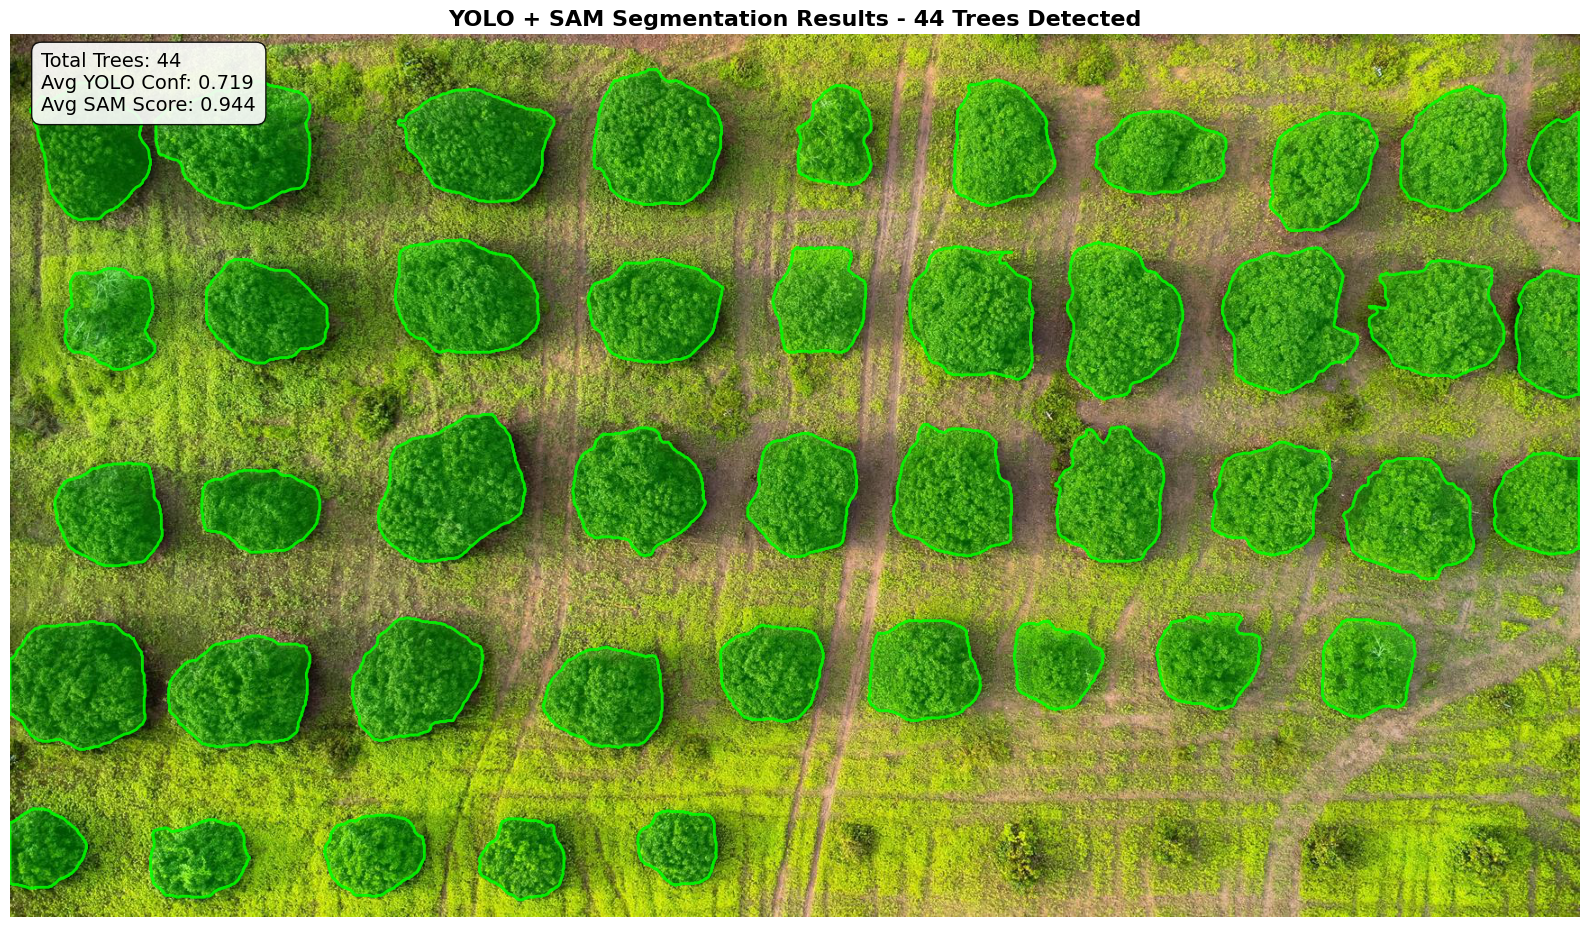

✓ Visualization saved to /content/drive/MyDrive/AGRI/TreeCrown_Segmentation/yolo_sam_segmentation.png
⚠ Skipping GeoJSON (no CRS)
✓ Saved CSV to /content/drive/MyDrive/AGRI/TreeCrown_Segmentation/tree_plantation_2_yolo_sam.csv
✓ Saved statistics to /content/drive/MyDrive/AGRI/TreeCrown_Segmentation/tree_plantation_2_statistics.json

✓ COMPLETED
✓ Total detections: 44 trees
✓ Processing time: 1167.12 seconds


In [ ]:
if __name__ == "__main__":
    from ultralytics import YOLO
    import os

    # Configuration
    IMAGE_PATH = "/content/drive/MyDrive/AGRI/TreeCrown_Segmentation/DJI_0245.JPG"
    YOLO_MODEL_PATH = "/content/drive/MyDrive/AGRI/Tree_Detection/models/yolo11n-100epoch.pt"
    OUTPUT_DIR = "/content/drive/MyDrive/AGRI/TreeCrown_Segmentation"
    SAM_MODEL_TYPE = "vit_b"  # Options: 'vit_h' (best), 'vit_l' (medium), 'vit_b' (fast)

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("="*60)
    print("YOLO DETECTION + SAM SEGMENTATION PIPELINE")
    print("="*60)

    # Step 1: YOLO Detection
    print("\n[Step 1/3] Loading YOLO model and detecting objects...")
    yolo_model = YOLO(YOLO_MODEL_PATH)

    boxes_list, full_image, image_dims, transform, crs = detect_with_yolo(
        image_path=IMAGE_PATH,
        model=yolo_model,
        tile_size=1280,
        overlap=0,
        resolution=0.50,
        conf_threshold=0.10,
        iou_threshold=0.45,
        max_det=1000,
        apply_nms=True,
        nms_iou=0.3
    )

    if len(boxes_list) == 0:
        print("❌ No objects detected by YOLO. Exiting.")
        exit()

    # Step 2: SAM Segmentation
    print(f"\n[Step 2/3] Segmenting {len(boxes_list)} objects with SAM...")
    segmentation_results = segment_with_sam(
        image=full_image,
        boxes_list=boxes_list,
        sam_checkpoint=None,  # Will auto-download
        model_type=SAM_MODEL_TYPE,
        device="cuda",
        checkpoint_dir=OUTPUT_DIR
    )

    # Step 3: Save and Visualize
    print("\n[Step 3/3] Creating outputs...")

    # Create GeoDataFrame
    gdf, detection_info = create_geodataframe(segmentation_results, transform, crs)

    # Visualize
    visualize_results(full_image, segmentation_results, OUTPUT_DIR)

    # Save results
    image_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]
    save_results(gdf, detection_info, OUTPUT_DIR, image_name)

    end_cpu_time = time.process_time()
    print("\n" + "="*60)
    print(f"✓ COMPLETED")
    print(f"✓ Total detections: {len(segmentation_results)} trees")
    print(f"✓ Processing time: {end_cpu_time - start_cpu_time:.2f} seconds")
    print("="*60)